## X-GBOOST

In [ ]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/timeseries/daily-total-female-births.csv

--2020-10-06 11:35:39--  https://frenzy86.s3.eu-west-2.amazonaws.com/timeseries/daily-total-female-births.csv
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.149.126
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.149.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6220 (6.1K) [application/vnd.ms-excel]
Saving to: ‘daily-total-female-births.csv.1’

daily-total-female- 100%[===================>]   6.07K  --.-KB/s    in 0s      

2020-10-06 11:35:39 (116 MB/s) - ‘daily-total-female-births.csv.1’ saved [6220/6220]



XGBoost is an efficient implementation of gradient boosting for classification and regression problems.

It is both fast and efficient, performing well, if not the best, on a wide range of predictive modeling tasks and is a favorite among data science competition winners, such as those on Kaggle.

XGBoost can also be used for time series forecasting, although it requires that the time series dataset be transformed into a supervised learning problem first. It also requires the use of a specialized technique for evaluating the model called walk-forward validation, as evaluating the model using k-fold cross validation would result in optimistically biased results.

In this tutorial, you will discover how to develop an XGBoost model for time series forecasting.

After completing this tutorial, you will know:

XGBoost is an implementation of the gradient boosting ensemble algorithm for classification and regression.
Time series datasets can be transformed into supervised learning using a sliding-window representation.
How to fit, evaluate, and make predictions with an XGBoost model for time series forecasting.

In [ ]:
import xgboost
print("xgboost", xgboost.__version__)

xgboost 0.90


### XGBoost for Time Series Forecasting
In this section, we will explore how to use XGBoost for time series forecasting.

We will use a standard univariate time series dataset with the intent of using the model to make a one-step forecast.

You can use the code in this section as the starting point in your own project and easily adapt it for multivariate inputs, multivariate forecasts, and multi-step forecasts.

We will use the daily female births dataset, that is the monthly births across three years.

You can download the dataset from here, place it in your current working directory with the filename “daily-total-female-births.csv“.

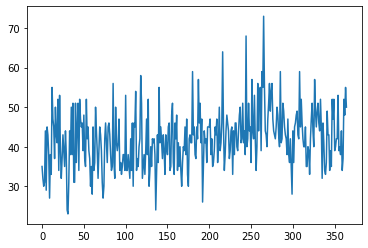

In [ ]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
series = read_csv('daily-total-female-births.csv', header=0, index_col=0)
values = series.values
# plot dataset
pyplot.plot(values)
pyplot.show()

A persistence model can achieve a MAE of about 6.7 births when predicting the last 12 months. This provides a baseline in performance above which a model may be considered skillful.

Next, we can evaluate the XGBoost model on the dataset when making one-step forecasts for the last 12 months of data.

We will use only the previous 6 time steps as input to the model and default model hyperparameters, except we will change the loss to ‘reg:squarederror‘ (to avoid a warning message) and use a 1,000 trees in the ensemble (to avoid underlearning).

The complete example is listed below.

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


>expected=42.0, predicted=39.7
>expected=53.0, predicted=41.3
>expected=39.0, predicted=35.0
>expected=40.0, predicted=33.6
>expected=38.0, predicted=41.8
>expected=44.0, predicted=50.8
>expected=34.0, predicted=41.5
>expected=37.0, predicted=35.4
>expected=52.0, predicted=35.1
>expected=48.0, predicted=45.6
>expected=55.0, predicted=46.2
>expected=50.0, predicted=55.3
MAE: 6.462


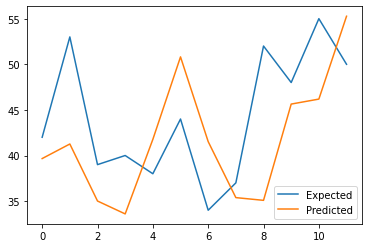

In [ ]:
# forecast monthly births with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

# load the dataset
series = read_csv('daily-total-female-births.csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

Running the example reports the expected and predicted values for each step in the test set, then the MAE for all predicted values.

Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

We can see that the model performs better than a persistence model, achieving a MAE of about 5.9 births, compared to 6.7 births.

Can you do better?
You can test different XGBoost hyperparameters and numbers of time steps as input to see if you can achieve better performance. Share your results in the comments below.

Once a final XGBoost model configuration is chosen, a model can be finalized and used to make a prediction on new data.

This is called an out-of-sample forecast, e.g. predicting beyond the training dataset. This is identical to making a prediction during the evaluation of the model: as we always want to evaluate a model using the same procedure that we expect to use when the model is used to make prediction on new data.

The example below demonstrates fitting a final XGBoost model on all available data and making a one-step prediction beyond the end of the dataset.

In [ ]:
# finalize model and make a prediction for monthly births with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from xgboost import XGBRegressor

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# load the dataset
series = read_csv('daily-total-female-births.csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=6)
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
# fit model
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)
# construct an input for a new preduction
row = values[-6:].flatten()
# make a one-step prediction
yhat = model.predict(asarray([row]))
print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

Input: [34 37 52 48 55 50], Predicted: 43.697


Running the example fits an XGBoost model on all available data.

A new row of input is prepared using the last 6 months of known data and the next month beyond the end of the dataset is predicted.

## Summary
In this tutorial, you discovered how to develop an XGBoost model for time series forecasting.

Specifically, you learned:

XGBoost is an implementation of the gradient boosting ensemble algorithm for classification and regression.
Time series datasets can be transformed into supervised learning using a sliding-window representation.
How to fit, evaluate, and make predictions with an XGBoost model for time series forecasting.